In [67]:
import psycopg2
import pandas as pd
import numpy as np
import nltk
import re
from collections import Counter
import spacy
import gensim 
import warnings
from keras.preprocessing.sequence import pad_sequences
from numpy import asarray
from numpy import zeros
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

# I. Load Data

In [2]:
conn = psycopg2.connect(database="threadtogether", user="dso_student", password="-H4jgA`rn6w`=Jg(", host="threadtogether.ychennay.com", port="5432")

In [3]:
# View all the tables
cur = conn.cursor()
cur.execute("""select *  
                            from information_schema.tables
                            where table_schema='public'""")
data = cur.fetchall()

In [4]:
pd.DataFrame(data, columns=[desc[0] for desc in cur.description])

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,threadtogether,public,full_data,BASE TABLE,None,None,None,None,None,YES,NO,None
1,threadtogether,public,womens_clothing_reviews,BASE TABLE,None,None,None,None,None,YES,NO,None
2,threadtogether,public,tagged_product_attributes,BASE TABLE,None,None,None,None,None,YES,NO,None
3,threadtogether,public,categories,BASE TABLE,None,None,None,None,None,YES,NO,None
4,threadtogether,public,outfits,BASE TABLE,None,None,None,None,None,YES,NO,None


In [5]:
# Extract data from full_data
cur = conn.cursor()
cur.execute("select *  from full_data")
data = cur.fetchall()

In [6]:
full_data = pd.DataFrame(data, columns=[desc[0] for desc in cur.description])

In [7]:
full_data.head()

,product_id,brand,mpn,product_full_name,description,brand_category,created_at,updated_at,deleted_at,brand_canonical_url,details,labels,bc_product_id
0,01DSE9TC2DQXDG6GWKW9NMJ416,Banana Republic,514683,Ankle-Strap Pump,"A modern pump, in a rounded silhouette with an...",Unknown,2019-11-11 22:37:15.719107+00,2019-12-19 20:40:30.786144+00,NULL,https://bananarepublic.gap.com/browse/product....,"A modern pump, in a rounded silhouette with an...","{""Needs Review""}",NULL
1,01DSE9SKM19XNA6SJP36JZC065,Banana Republic,526676,Petite Tie-Neck Top,Dress it down with jeans and sneakers or dress...,Unknown,2019-11-11 22:36:50.682513+00,2019-12-19 20:40:30.786144+00,NULL,https://bananarepublic.gap.com/browse/product....,Dress it down with jeans and sneakers or dress...,"{""Needs Review""}",NULL
2,01DSJX8GD4DSAP76SPR85HRCMN,Loewe,4.001E+11,52MM Padded Leather Round Sunglasses,Padded leather covers classic round sunglasses.,JewelryAccessories/SunglassesReaders/RoundOval...,2019-11-13 17:33:59.581661+00,2019-12-19 20:40:30.786144+00,NULL,https://www.saksfifthavenue.com/loewe-52mm-pad...,100% UV protection\nCase and cleaning cloth in...,"{""Needs Review""}",NULL
3,01DSJVKJNS6F4KQ1QM6YYK9AW2,Converse,4.00012E+11,Baby's & Little Kid's All-Star Two-Tone Mid-To...,The iconic mid-top design gets an added dose o...,"JustKids/Shoes/Baby024Months/BabyGirl,JustKids...",2019-11-13 17:05:05.203733+00,2019-12-19 20:40:30.786144+00,NULL,https://www.saksfifthavenue.com/converse-babys...,Canvas upper\nRound toe\nLace-up vamp\nSmartFO...,"{""Needs Review""}",NULL
4,01DSK15ZD4D5A0QXA8NSD25YXE,Alexander McQueen,4.00011E+11,64MM Rimless Sunglasses,Hexagonal shades offer a rimless view with int...,JewelryAccessories/SunglassesReaders/RoundOval,2019-11-13 18:42:30.941321+00,2019-12-19 20:40:30.786144+00,NULL,https://www.saksfifthavenue.com/alexander-mcqu...,100% UV protection\nGradient lenses\nAdjustabl...,"{""Needs Review""}",NULL


In [8]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48979 entries, 0 to 48978
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           48979 non-null  object
 1   brand                48979 non-null  object
 2   mpn                  48979 non-null  object
 3   product_full_name    48979 non-null  object
 4   description          41005 non-null  object
 5   brand_category       48741 non-null  object
 6   created_at           48979 non-null  object
 7   updated_at           48979 non-null  object
 8   deleted_at           45984 non-null  object
 9   brand_canonical_url  48967 non-null  object
 10  details              47950 non-null  object
 11  labels               48979 non-null  object
 12  bc_product_id        48979 non-null  object
dtypes: object(13)
memory usage: 4.9+ MB


In [9]:
# Extract data from tagged_product_attributes
cur = conn.cursor()
cur.execute("select *  from tagged_product_attributes")
data = cur.fetchall()

In [10]:
tagged_data = pd.DataFrame(data, columns=[desc[0] for desc in cur.description])

In [11]:
tagged_data.head()

,product_id,product_color_id,attribute_name,attribute_value,file
0,01DVBTBPHR8WJTCVEN5AJRHF47,01DVBTBPJ41VVT00JJCG8TTZ2W,gender,Women,initial_tags
1,01DVA7QRXM928ZM0WWR7HFNTC1,01DVA7QRXXR9F0TWVE1HMC5ZQ3,Primary Color,Blacks,initial_tags
2,01DPGV4YRP3Z8J85DASGZ1Y99W,01DPGVGBK6YGNYGNF2S6FSH02T,style,Casual,initial_tags
3,01E1JM43NQ3H17PB22EV3074NX,01E1JM5WFWWCCCH3JTTTCYQCEQ,style,Modern,initial_tags
4,01DSE8Z2ZDAZKZ2SKCS1E3B3HK,01DSE8ZG8Y3FR8KWE2TY1QDWBF,shoe_width,Medium,initial_tags


In [12]:
tagged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119345 entries, 0 to 119344
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   product_id        119345 non-null  object
 1   product_color_id  119345 non-null  object
 2   attribute_name    119345 non-null  object
 3   attribute_value   119345 non-null  object
 4   file              119345 non-null  object
dtypes: object(5)
memory usage: 4.6+ MB


In [13]:
# Extract data from womens_clothing_reviews
cur = conn.cursor()
cur.execute("select *  from womens_clothing_reviews")
data = cur.fetchall()

In [14]:
reviews = pd.DataFrame(data, columns=[desc[0] for desc in cur.description])

In [15]:
reviews.head()

,clothing_id,age,title,review_text,rating,recommend,likes,division,department,class
0,767,33,None,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,None,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [16]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   clothing_id  23486 non-null  int64 
 1   age          23486 non-null  int64 
 2   title        19676 non-null  object
 3   review_text  22641 non-null  object
 4   rating       23486 non-null  int64 
 5   recommend    23486 non-null  int64 
 6   likes        23486 non-null  int64 
 7   division     23472 non-null  object
 8   department   23472 non-null  object
 9   class        23472 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.8+ MB


In [17]:
# Extract data from categories
cur = conn.cursor()
cur.execute("select *  from categories")
data = cur.fetchall()

In [18]:
# View
pd.DataFrame(data, columns=[desc[0] for desc in cur.description]).head()

,value,category,type,quantifier
0,Androgynous,style,general,many
1,Athleisure,style,general,many
2,Boho,style,general,many
3,Business Casual,style,general,many
4,Casual,style,general,many


In [19]:
# Extract data from outfits
cur = conn.cursor()
cur.execute("select *  from outfits")
data = cur.fetchall()

In [20]:
# View
pd.DataFrame(data, columns=[desc[0] for desc in cur.description]).head()

,outfit_id,product_color_id,outfit_item_type
0,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA2S83FARJW4QWRBXNS,shoe
1,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA2V2Y8EN8YPY1E16EV,accessory1
2,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA23E5A8GBES8QJN3HF,top
3,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA2C7BQN0X7MNNYXBHW,bottom
4,01DMHCX50CFX5YNG99F3Y65GQW,01DMBRYVA2S83FARJW4QWRBXNS,shoe


In [21]:
outfit = pd.DataFrame(data, columns=[desc[0] for desc in cur.description])

In [22]:
np.unique(outfit['outfit_item_type'])

array(['accessory1', 'accessory2', 'accessory3', 'bottom', 'onepiece',
       'shoe', 'top'], dtype=object)

# II. Text Preprocessing

In [23]:
# join full_data and tagged_data. Replace NAs and \n
join_data = full_data.merge(tagged_data, on='product_id')
join_data = join_data.replace(np.nan, "", regex=True)
join_data = join_data.replace("\n", "",regex=True)
join_data['attribute_value'].replace(r'\bbusinesscasual\b', 'business casual', inplace=True, regex=True)
join_data.head(3)

,product_id,brand,mpn,product_full_name,description,brand_category,created_at,updated_at,deleted_at,brand_canonical_url,details,labels,bc_product_id,product_color_id,attribute_name,attribute_value,file
0,01E5ZXP5H0BTEZT9QD2HRZJ47A,A.L.C.,5529544,Lennox High Waist Cotton & Linen Pants,High-rise trousers tailored from a cool Italia...,Unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"True to size. High rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,linenblend,additional
1,01E5ZXP5H0BTEZT9QD2HRZJ47A,A.L.C.,5529544,Lennox High Waist Cotton & Linen Pants,High-rise trousers tailored from a cool Italia...,Unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"True to size. High rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,cottonblend,additional
2,01E5ZXP5H0BTEZT9QD2HRZJ47A,A.L.C.,5529544,Lennox High Waist Cotton & Linen Pants,High-rise trousers tailored from a cool Italia...,Unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"True to size. High rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,style,modern,additional


In [24]:
# Lower case some target texts
columns_list = ['brand','product_full_name','description','brand_category','details',
                'attribute_name','attribute_value']
for column in columns_list:
    join_data[column] = join_data[column].str.lower()
join_data.head(3)

,product_id,brand,mpn,product_full_name,description,brand_category,created_at,updated_at,deleted_at,brand_canonical_url,details,labels,bc_product_id,product_color_id,attribute_name,attribute_value,file
0,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c.,5529544,lennox high waist cotton & linen pants,high-rise trousers tailored from a cool italia...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"true to size. high rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,linenblend,additional
1,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c.,5529544,lennox high waist cotton & linen pants,high-rise trousers tailored from a cool italia...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"true to size. high rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,cottonblend,additional
2,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c.,5529544,lennox high waist cotton & linen pants,high-rise trousers tailored from a cool italia...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"true to size. high rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,style,modern,additional


In [25]:
# Remove stopwords
from nltk.corpus import stopwords
from nltk import word_tokenize

columns_list2 = ['brand','product_full_name','description','brand_category','details']
nltk_stopwords = set(stopwords.words('english') + [".",",",":","''","'s","'","``","(", ")","]",
                                                   "-","!","/",">","<",";","#","...","..","?","--","[","&"])
for column in columns_list2:
    join_data[column] = join_data[column].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in nltk_stopwords]))
    
join_data.head(3)

,product_id,brand,mpn,product_full_name,description,brand_category,created_at,updated_at,deleted_at,brand_canonical_url,details,labels,bc_product_id,product_color_id,attribute_name,attribute_value,file
0,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c,5529544,lennox high waist cotton linen pants,high-rise trousers tailored cool italian cotto...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,true size high rise.31 inseam 14 leg opening 1...,[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,linenblend,additional
1,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c,5529544,lennox high waist cotton linen pants,high-rise trousers tailored cool italian cotto...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,true size high rise.31 inseam 14 leg opening 1...,[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,cottonblend,additional
2,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c,5529544,lennox high waist cotton linen pants,high-rise trousers tailored cool italian cotto...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,true size high rise.31 inseam 14 leg opening 1...,[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,style,modern,additional


In [26]:
# Lemmatization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

for column in columns_list2:
    join_data[column] = join_data[column].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

# III. Modelling

In [27]:
# Michael's way of finding input texts you need (for reference) 
join_data['tag_info'] = join_data[['brand','product_full_name','brand_category','details','description']].apply(lambda x: ' '.join(x), axis=1)
join_data['tag_info'][0]

'a.l.c lennox high waist cotton linen pant unknown true size high rise.31 inseam 14 leg opening 12 front rise 15 1/2 back rise size 8 zip fly hook-and-bar closurefront slant pocket back welt pockets67 % cotton 33 % linendry cleanimportedvia c high-rise trouser tailored cool italian cotton-and-linen blend make refreshing addition work wardrobe'

In [28]:
Style = join_data[join_data['attribute_name']=='style'][['tag_info', 'attribute_value']]

In [29]:
Style.shape

(25539, 2)

In [30]:
Style = join_data[join_data['attribute_name']=='style'][['tag_info', 'attribute_value']].drop_duplicates()

In [31]:
Style.shape

(10971, 2)

In [32]:
stylelist = list(np.unique(Style['attribute_value']))

In [33]:
stylelist

['androgynous',
 'athleisure',
 'boho',
 'business casual',
 'casual',
 'classic',
 'edgy',
 'glam',
 'modern',
 'retro',
 'romantic']

In [34]:
stylelist = list(np.unique(Style['attribute_value']))

In [35]:
Style.reset_index(drop=True, inplace=True)

## LSTM

In [199]:
# Load in GloVe Vectors
def load_glove_vectors():
    embeddings_index = {}
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index

embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


In [98]:
for sty in np.unique(Style['attribute_value']):
    Style[sty] = 0
    Style[sty][Style['attribute_value']==sty]=1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [99]:
Style.head(10)

,tag_info,attribute_value,androgynous,athleisure,boho,business casual,casual,classic,edgy,glam,modern,retro,romantic
0,a.l.c lennox high waist cotton linen pant unkn...,modern,0,0,0,0,0,0,0,0,1,0,0
1,a.l.c lennox high waist cotton linen pant unkn...,business casual,0,0,0,1,0,0,0,0,0,0,0
2,a.l.c lennox high waist cotton linen pant unkn...,classic,0,0,0,0,0,1,0,0,0,0,0
3,banana republic mock-neck sweater top unknown ...,classic,0,0,0,0,0,1,0,0,0,0,0
4,banana republic mock-neck sweater top unknown ...,business casual,0,0,0,1,0,0,0,0,0,0,0
5,simon miller rost belted short unknown true si...,modern,0,0,0,0,0,0,0,0,1,0,0
6,simon miller rost belted short unknown true si...,casual,0,0,0,0,1,0,0,0,0,0,0
7,simon miller rost belted short unknown true si...,androgynous,1,0,0,0,0,0,0,0,0,0,0
8,a.l.c minelli silk sleeveless top unknown true...,modern,0,0,0,0,0,0,0,0,1,0,0
9,a.l.c minelli silk sleeveless top unknown true...,boho,0,0,1,0,0,0,0,0,0,0,0


In [347]:
androgynous_data = Style.groupby('tag_info').agg(androgynous = pd.NamedAgg(column='androgynous', aggfunc='max')).reset_index()

In [348]:
androgynous_data.head(5)

,tag_info,androgynous
0,360 cashmere ella plaid crop sweater womensapp...,1
1,7 mankind cowl satin tank top womensapparel/to...,0
2,7 mankind® 7 mankind high waist skinny jean un...,0
3,7 mankind® 7 mankind modern dojo wide leg jean...,0
4,7 mankind® alexa crop wide leg high waist jean...,0


In [349]:
androgynous_data1 = androgynous_data[androgynous_data['androgynous']==1]

In [350]:
androgynous_data2 = androgynous_data[androgynous_data['androgynous']==0].sample(round(len(androgynous_data1)*1.5), random_state=123)

In [351]:
androgynous_data = pd.concat([androgynous_data1, androgynous_data2])

In [352]:
tag_list = list(androgynous_data['tag_info'])

In [353]:
# Tokenize the Text
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(tag_list)

In [354]:
# Integer Encode Tokens
from typing import List
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

# Get Max Length Per Token
def get_max_token_length_per_doc(docs: List[List[str]])-> int:
    return max(list(map(lambda x: len(x.split()), docs)))

# get the max length in terms of token length
max_length = get_max_token_length_per_doc(tag_list)

print(max_length)

143


In [355]:
############################ CHANGE PADDING HERE

# integer encode the documents
encoded_docs = integer_encode_documents(tag_list, tokenizer)
# this is a list of lists, the numbers represent the index position of that word.
# for instance, 33 means the 33rd word in the vocabulary
# Notice the last document has 4 numbers, since it is a 4 word document: Could have done better.
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [356]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = androgynous_data['androgynous']
labels = to_categorical(encoder.fit_transform(labels))

In [357]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.1, random_state=23)

In [358]:
# Use smote
# from imblearn.over_sampling import SMOTE
# smo = SMOTE(random_state=123)
# X_train, y_train = smo.fit_sample(X_train, y_train)
# y_train = to_categorical(y_train)

In [359]:
# Import Keras Toolkit
from random import randint
from numpy import array, argmax, asarray, zeros
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding

In [360]:
VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

In [361]:
# Load in Embeddings
# create a weight matrix for words in training docs
embedding_matrix = zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

In [362]:
# Define in Model

from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Flatten, Masking
# define model

def make_multiple_classification_rnn_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(SimpleRNN(units=64, input_shape=(1, max_length)))
    # model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(2, activation='sigmoid'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

def make_lstm_classification_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=32, input_shape=(1, max_length)))
    # model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(2, activation='sigmoid'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

## Compile Model

#### Helpful Rule of Thumb for Defining # of Parameters in LSTM:

$$
W = 4d×(n+d)
$$
Where $d$ is the number of memory cells, and $N$ is the number of dimensions for a data point.

In [363]:
model = make_lstm_classification_model()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 143, 100)          735600    
_________________________________________________________________
masking_11 (Masking)         (None, 143, 100)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dense_21 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 18        
Total params: 752,906
Trainable params: 17,306
Non-trainable params: 735,600
_________________________________________________________________


## Fit the Model

In [364]:
# fit the model
history = model.fit(X_train, y_train,validation_split = 0.1, epochs=15, verbose=1)

Train on 1494 samples, validate on 166 samples
Epoch 1/15
1494/1494 [==============================] - 5s 3ms/step - loss: 0.6687 - accuracy: 0.5964 - val_loss: 0.6893 - val_accuracy: 0.5542
Epoch 2/15
1494/1494 [==============================] - 4s 2ms/step - loss: 0.6413 - accuracy: 0.6359 - val_loss: 0.6306 - val_accuracy: 0.6145
Epoch 3/15
1494/1494 [==============================] - 4s 2ms/step - loss: 0.6014 - accuracy: 0.6627 - val_loss: 0.5746 - val_accuracy: 0.6988
Epoch 4/15
1494/1494 [==============================] - 4s 3ms/step - loss: 0.5557 - accuracy: 0.7122 - val_loss: 0.5577 - val_accuracy: 0.6867
Epoch 5/15
1494/1494 [==============================] - 4s 3ms/step - loss: 0.5076 - accuracy: 0.7530 - val_loss: 0.5242 - val_accuracy: 0.7349
Epoch 6/15
1494/1494 [==============================] - 4s 2ms/step - loss: 0.4698 - accuracy: 0.7704 - val_loss: 0.5911 - val_accuracy: 0.6928
Epoch 7/15
1494/1494 [==============================] - 4s 2ms/step - loss: 0.4384 - accu

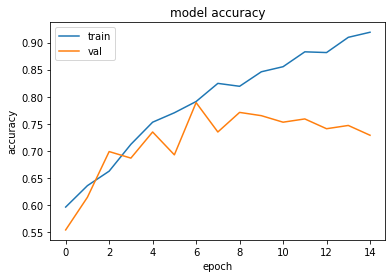

In [365]:
import keras
from matplotlib import pyplot as plt

def plot_fit_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot_fit_history(history)

In [366]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

185/185 [==============================] - 0s 873us/step
Accuracy: 72.432435


In [367]:
pred_prob = model.predict(X_test, verbose = 0)

In [368]:
pred_prob[0:10]

array([[0.04446846, 0.27163857],
       [0.5144995 , 0.00883508],
       [0.04454634, 0.713166  ],
       [0.03167582, 0.4782149 ],
       [0.8771125 , 0.0024575 ],
       [0.15399185, 0.05233788],
       [0.00376213, 0.24723393],
       [0.37055007, 0.37748793],
       [0.15586042, 0.00384307],
       [0.06693441, 0.1450625 ]], dtype=float32)

In [369]:
1-np.mean(androgynous_data['androgynous'])

0.6

In [370]:
y_prob = model.predict(X_test) 
y_classes = y_prob.argmax(axis=-1)

In [371]:
ytest = [np.argmax(y, axis=None, out=None) for y in y_test]

In [372]:
import sklearn
sklearn.metrics.confusion_matrix(ytest, y_classes)

array([[81, 31],
       [20, 53]], dtype=int64)

In [373]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(ytest, y_classes).ravel()
(tn, fp, fn, tp)

(81, 31, 20, 53)

In [374]:
# acc
sklearn.metrics. accuracy_score(ytest, y_classes)

0.7243243243243244

In [375]:
# precision 
sklearn.metrics.precision_score(ytest, y_classes)

0.6309523809523809

In [376]:
# recall
sklearn.metrics.recall_score(ytest, y_classes)

0.726027397260274

In [377]:
# auc
sklearn.metrics.roc_auc_score(ytest, [y[1] for y in y_prob])

0.75

### Try different dense layer - Actually could try more adjustment if we have more time & resources

In [389]:
acclist = []
precisionlist = []
recalllist = []
auclist = []
for dense_num in range(4, 40, 8):
    print(dense_num,'=========================')
    for loop in range(10):
        androgynous_data = Style.groupby('tag_info').agg(androgynous = pd.NamedAgg(column='androgynous', aggfunc='max')).reset_index()
        androgynous_data1 = androgynous_data[androgynous_data['androgynous']==1]
        androgynous_data2 = androgynous_data[androgynous_data['androgynous']==0].sample(round(len(androgynous_data1)*1.5), random_state=123)
        androgynous_data = pd.concat([androgynous_data1, androgynous_data2])
        tag_list = list(androgynous_data['tag_info'])

        # Tokenize the Text
        tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
        tokenizer.fit_on_texts(tag_list)

        # get the max length in terms of token length
        max_length = get_max_token_length_per_doc(tag_list)

        ############################ CHANGE PADDING HERE

        # integer encode the documents
        encoded_docs = integer_encode_documents(tag_list, tokenizer)
        # this is a list of lists, the numbers represent the index position of that word.
        # for instance, 33 means the 33rd word in the vocabulary
        # Notice the last document has 4 numbers, since it is a 4 word document: Could have done better.
        padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

        encoder = LabelEncoder()
        labels = androgynous_data['androgynous']
        labels = to_categorical(encoder.fit_transform(labels))

        X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.1, random_state=23)

        VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

        # Load in Embeddings
        # create a weight matrix for words in training docs
        embedding_matrix = zeros((VOCAB_SIZE, 100))
        for word, i in tokenizer.word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None: # check that it is an actual word that we have embeddings for
                embedding_matrix[i] = embedding_vector

        # define model

        def make_lstm_classification_model(plot=False):
            model = Sequential()
            model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
            model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
            model.add(LSTM(units=32, input_shape=(1, max_length)))
            # model.add(Dense(16))
            model.add(Dense(dense_num))
            model.add(Dense(2, activation='sigmoid'))

            # Compile the model
            model.compile(
            optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            # summarize the model
            # model.summary()

            if plot:
                plot_model(model, to_file='model.png', show_shapes=True)
            return model

        model = make_lstm_classification_model()

        # fit the model
        history = model.fit(X_train, y_train,validation_split = 0.1, epochs=15, verbose=0)
        # plot_fit_history(history)

        y_prob = model.predict(X_test) 
        y_classes = y_prob.argmax(axis=-1)
        ytest = [np.argmax(y, axis=None, out=None) for y in y_test]
        # acc
        acc = sklearn.metrics.accuracy_score(ytest, y_classes)
        # print('acc: %f' % acc)
        # precision 
        precision = sklearn.metrics.precision_score(ytest, y_classes)
#         print('precision: %f' % precision)
        # recall
        recall = sklearn.metrics.recall_score(ytest, y_classes)
#         print('recall: %f' % recall)
        # auc
        auc = sklearn.metrics.roc_auc_score(ytest, [y[1] for y in y_prob])
#         print('auc: %f' % auc)

        acclist.append(acc)
        precisionlist.append(precision)
        recalllist.append(recall)
        auclist.append(auc)
    print('acc: %f' % np.mean(acclist))
    print('precision: %f' % np.mean(precisionlist))
    print('recall: %f' % np.mean(recalllist))
    print('auc: %f' % np.mean(auclist))

4 =========================
acc: 0.740541
precision: 0.689683
recall: 0.626027
auc: 0.794998
12 =========================
acc: 0.739730
precision: 0.681197
recall: 0.651370
auc: 0.791249
20 =========================
acc: 0.740360
precision: 0.678781
recall: 0.661187
auc: 0.790431
28 =========================
acc: 0.739730
precision: 0.675626
recall: 0.665753
auc: 0.787420
36 =========================
acc: 0.737297
precision: 0.673547
recall: 0.657808
auc: 0.785856


In [391]:
acclist = []
precisionlist = []
recalllist = []
auclist = []
for dense_num in range(2, 3, 2):
    print(dense_num,'=========================')
    for loop in range(10):
        androgynous_data = Style.groupby('tag_info').agg(androgynous = pd.NamedAgg(column='androgynous', aggfunc='max')).reset_index()
        androgynous_data1 = androgynous_data[androgynous_data['androgynous']==1]
        androgynous_data2 = androgynous_data[androgynous_data['androgynous']==0].sample(round(len(androgynous_data1)*1.5), random_state=123)
        androgynous_data = pd.concat([androgynous_data1, androgynous_data2])
        tag_list = list(androgynous_data['tag_info'])

        # Tokenize the Text
        tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
        tokenizer.fit_on_texts(tag_list)

        # get the max length in terms of token length
        max_length = get_max_token_length_per_doc(tag_list)

        ############################ CHANGE PADDING HERE

        # integer encode the documents
        encoded_docs = integer_encode_documents(tag_list, tokenizer)
        # this is a list of lists, the numbers represent the index position of that word.
        # for instance, 33 means the 33rd word in the vocabulary
        # Notice the last document has 4 numbers, since it is a 4 word document: Could have done better.
        padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

        encoder = LabelEncoder()
        labels = androgynous_data['androgynous']
        labels = to_categorical(encoder.fit_transform(labels))

        X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.1, random_state=23)

        VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

        # Load in Embeddings
        # create a weight matrix for words in training docs
        embedding_matrix = zeros((VOCAB_SIZE, 100))
        for word, i in tokenizer.word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None: # check that it is an actual word that we have embeddings for
                embedding_matrix[i] = embedding_vector

        # define model

        def make_lstm_classification_model(plot=False):
            model = Sequential()
            model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
            model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
            model.add(LSTM(units=32, input_shape=(1, max_length)))
            # model.add(Dense(16))
            model.add(Dense(dense_num))
            model.add(Dense(2, activation='sigmoid'))

            # Compile the model
            model.compile(
            optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            # summarize the model
            # model.summary()

            if plot:
                plot_model(model, to_file='model.png', show_shapes=True)
            return model

        model = make_lstm_classification_model()

        # fit the model
        history = model.fit(X_train, y_train,validation_split = 0.1, epochs=15, verbose=0)
        # plot_fit_history(history)

        y_prob = model.predict(X_test) 
        y_classes = y_prob.argmax(axis=-1)
        ytest = [np.argmax(y, axis=None, out=None) for y in y_test]
        # acc
        acc = sklearn.metrics.accuracy_score(ytest, y_classes)
        # print('acc: %f' % acc)
        # precision 
        precision = sklearn.metrics.precision_score(ytest, y_classes)
#         print('precision: %f' % precision)
        # recall
        recall = sklearn.metrics.recall_score(ytest, y_classes)
#         print('recall: %f' % recall)
        # auc
        auc = sklearn.metrics.roc_auc_score(ytest, [y[1] for y in y_prob])
#         print('auc: %f' % auc)

        acclist.append(acc)
        precisionlist.append(precision)
        recalllist.append(recall)
        auclist.append(auc)
    print('acc: %f' % np.mean(acclist))
    print('precision: %f' % np.mean(precisionlist))
    print('recall: %f' % np.mean(recalllist))
    print('auc: %f' % np.mean(auclist))

6 =========================
acc: 0.735135
precision: 0.665959
recall: 0.682192
auc: 0.793408
8 =========================
acc: 0.744054
precision: 0.682210
recall: 0.673973
auc: 0.801046
10 =========================


KeyboardInterrupt: 

In [392]:
acclist = []
precisionlist = []
recalllist = []
auclist = []
for dense_num in ['nolayer']:
    print(dense_num,'=========================')
    for loop in range(10):
        androgynous_data = Style.groupby('tag_info').agg(androgynous = pd.NamedAgg(column='androgynous', aggfunc='max')).reset_index()
        androgynous_data1 = androgynous_data[androgynous_data['androgynous']==1]
        androgynous_data2 = androgynous_data[androgynous_data['androgynous']==0].sample(round(len(androgynous_data1)*1.5), random_state=123)
        androgynous_data = pd.concat([androgynous_data1, androgynous_data2])
        tag_list = list(androgynous_data['tag_info'])

        # Tokenize the Text
        tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
        tokenizer.fit_on_texts(tag_list)

        # get the max length in terms of token length
        max_length = get_max_token_length_per_doc(tag_list)

        ############################ CHANGE PADDING HERE

        # integer encode the documents
        encoded_docs = integer_encode_documents(tag_list, tokenizer)
        # this is a list of lists, the numbers represent the index position of that word.
        # for instance, 33 means the 33rd word in the vocabulary
        # Notice the last document has 4 numbers, since it is a 4 word document: Could have done better.
        padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

        encoder = LabelEncoder()
        labels = androgynous_data['androgynous']
        labels = to_categorical(encoder.fit_transform(labels))

        X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.1, random_state=23)

        VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

        # Load in Embeddings
        # create a weight matrix for words in training docs
        embedding_matrix = zeros((VOCAB_SIZE, 100))
        for word, i in tokenizer.word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None: # check that it is an actual word that we have embeddings for
                embedding_matrix[i] = embedding_vector

        # define model

        def make_lstm_classification_model(plot=False):
            model = Sequential()
            model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
            model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
            model.add(LSTM(units=32, input_shape=(1, max_length)))
            # model.add(Dense(16))
            model.add(Dense(2, activation='sigmoid'))

            # Compile the model
            model.compile(
            optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            # summarize the model
            # model.summary()

            if plot:
                plot_model(model, to_file='model.png', show_shapes=True)
            return model

        model = make_lstm_classification_model()

        # fit the model
        history = model.fit(X_train, y_train,validation_split = 0.1, epochs=15, verbose=0)
        # plot_fit_history(history)

        y_prob = model.predict(X_test) 
        y_classes = y_prob.argmax(axis=-1)
        ytest = [np.argmax(y, axis=None, out=None) for y in y_test]
        # acc
        acc = sklearn.metrics.accuracy_score(ytest, y_classes)
        # print('acc: %f' % acc)
        # precision 
        precision = sklearn.metrics.precision_score(ytest, y_classes)
#         print('precision: %f' % precision)
        # recall
        recall = sklearn.metrics.recall_score(ytest, y_classes)
#         print('recall: %f' % recall)
        # auc
        auc = sklearn.metrics.roc_auc_score(ytest, [y[1] for y in y_prob])
#         print('auc: %f' % auc)

        acclist.append(acc)
        precisionlist.append(precision)
        recalllist.append(recall)
        auclist.append(auc)
    print('acc: %f' % np.mean(acclist))
    print('precision: %f' % np.mean(precisionlist))
    print('recall: %f' % np.mean(recalllist))
    print('auc: %f' % np.mean(auclist))

nolayer =========================
acc: 0.738919
precision: 0.657784
recall: 0.726027
auc: 0.793065


### Try different sample size

In [394]:
acclist = []
precisionlist = []
recalllist = []
auclist = []
for size_num in range(10, 31, 1):
    size_num /= 10
    print(size_num,'=========================')
    for loop in range(10):
        androgynous_data = Style.groupby('tag_info').agg(androgynous = pd.NamedAgg(column='androgynous', aggfunc='max')).reset_index()
        androgynous_data1 = androgynous_data[androgynous_data['androgynous']==1]
        androgynous_data2 = androgynous_data[androgynous_data['androgynous']==0].sample(round(len(androgynous_data1)*size_num), random_state=123)
        androgynous_data = pd.concat([androgynous_data1, androgynous_data2])
        tag_list = list(androgynous_data['tag_info'])

        # Tokenize the Text
        tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
        tokenizer.fit_on_texts(tag_list)

        # get the max length in terms of token length
        max_length = get_max_token_length_per_doc(tag_list)

        ############################ CHANGE PADDING HERE

        # integer encode the documents
        encoded_docs = integer_encode_documents(tag_list, tokenizer)
        padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

        encoder = LabelEncoder()
        labels = androgynous_data['androgynous']
        labels = to_categorical(encoder.fit_transform(labels))

        X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.1, random_state=23)

        VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

        # Load in Embeddings
        # create a weight matrix for words in training docs
        embedding_matrix = zeros((VOCAB_SIZE, 100))
        for word, i in tokenizer.word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None: # check that it is an actual word that we have embeddings for
                embedding_matrix[i] = embedding_vector

        # define model

        def make_lstm_classification_model(plot=False):
            model = Sequential()
            model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
            model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
            model.add(LSTM(units=32, input_shape=(1, max_length)))
            # model.add(Dense(16))
            model.add(Dense(8))
            model.add(Dense(2, activation='sigmoid'))

            # Compile the model
            model.compile(
            optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            # summarize the model
            # model.summary()

            if plot:
                plot_model(model, to_file='model.png', show_shapes=True)
            return model

        model = make_lstm_classification_model()

        # fit the model
        history = model.fit(X_train, y_train,validation_split = 0.1, epochs=15, verbose=0)
        # plot_fit_history(history)

        y_prob = model.predict(X_test) 
        y_classes = y_prob.argmax(axis=-1)
        ytest = [np.argmax(y, axis=None, out=None) for y in y_test]
        # acc
        acc = sklearn.metrics.accuracy_score(ytest, y_classes)
        # precision 
        precision = sklearn.metrics.precision_score(ytest, y_classes)
        # recall
        recall = sklearn.metrics.recall_score(ytest, y_classes)
        # auc
        auc = sklearn.metrics.roc_auc_score(ytest, [y[1] for y in y_prob])

        acclist.append(acc)
        precisionlist.append(precision)
        recalllist.append(recall)
        auclist.append(auc)
    print('acc: %f' % np.mean(acclist))
    print('precision: %f' % np.mean(precisionlist))
    print('recall: %f' % np.mean(recalllist))
    print('auc: %f' % np.mean(auclist))

1.0 =========================
acc: 0.706081
precision: 0.616230
recall: 0.772131
auc: 0.774053
1.1 =========================
acc: 0.716266
precision: 0.611659
recall: 0.775721
auc: 0.777126
1.2 =========================
acc: 0.717388
precision: 0.632041
recall: 0.773592
auc: 0.781342
1.3 =========================
acc: 0.722453
precision: 0.660609
recall: 0.742694
auc: 0.796705
1.4 =========================
acc: 0.726277
precision: 0.670427
recall: 0.716408
auc: 0.800644
1.5 =========================
acc: 0.727213
precision: 0.668327
recall: 0.711847
auc: 0.801173
1.6 =========================
acc: 0.728310
precision: 0.669492
recall: 0.702072
auc: 0.801407
1.7 =========================
acc: 0.730022
precision: 0.670665
recall: 0.691813
auc: 0.802030
1.8 =========================
acc: 0.732322
precision: 0.677012
recall: 0.679112
auc: 0.801379
1.9 =========================
acc: 0.734183
precision: 0.676259
recall: 0.672239
auc: 0.800903
2.0 =========================
acc: 0.736645
precis

KeyboardInterrupt: 

## LSTM for all styles

In [ ]:
# Redefine model

def make_lstm_classification_model(plot=False):
        model = Sequential()
        model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
        model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
        model.add(LSTM(units=32, input_shape=(1, max_length)))
        # model.add(Dense(16))
        model.add(Dense(8))
        model.add(Dense(2, activation='sigmoid'))

        # Compile the model
        model.compile(
        optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        # summarize the model
        # model.summary()

        if plot:
            plot_model(model, to_file='model.png', show_shapes=True)
        return model

In [97]:
stylelist

['androgynous',
 'athlete leisure',
 'boho',
 'business casual',
 'casual',
 'classic',
 'edgy',
 'glam',
 'modern',
 'retro',
 'romantic']

androgynous =========================================
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 169, 100)          649900    
_________________________________________________________________
masking_6 (Masking)          (None, 169, 100)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 10        
Total params: 667,066
Trainable params: 17,166
Non-trainable params: 649,900
_________________________________________________________________
Train on 1248 samples, validate on 139 samples
Epoch 1/

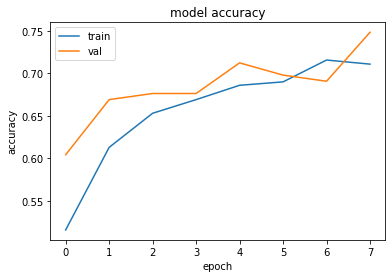

155/155 [==============================] - 0s 1ms/step
Accuracy: 67.741936
Original Accuracy: 0.521401
Confusion Matrix:  [[54 37]
 [13 51]]
tn, fp, fn, tp:   54 37 13 51
acc: 0.677419
precision: 0.579545
recall: 0.796875
auc: 0.734203
athlete leisure =========================================
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 145, 100)          556400    
_________________________________________________________________
masking_7 (Masking)          (None, 145, 100)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_14 (Dense)        

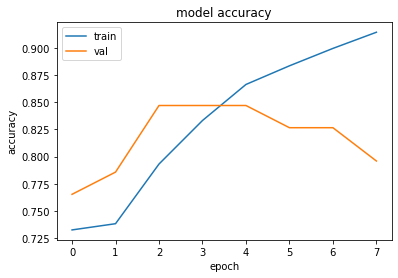

109/109 [==============================] - 0s 1ms/step
Accuracy: 89.908254
Original Accuracy: 0.739372
Confusion Matrix:  [[73 10]
 [ 1 25]]
tn, fp, fn, tp:   73 10 1 25
acc: 0.899083
precision: 0.714286
recall: 0.961538
auc: 0.951807
boho =========================================
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 128, 100)          596200    
_________________________________________________________________
masking_8 (Masking)          (None, 128, 100)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_16 (Dense)             (None, 

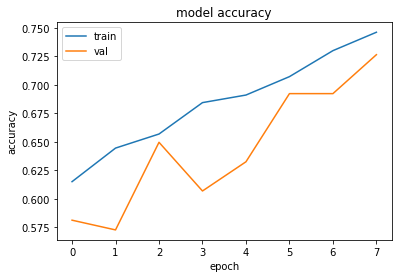

130/130 [==============================] - 0s 978us/step
Accuracy: 73.076922
Original Accuracy: 0.618938
Confusion Matrix:  [[65 18]
 [17 30]]
tn, fp, fn, tp:   65 18 17 30
acc: 0.730769
precision: 0.625000
recall: 0.638298
auc: 0.740836
business casual =========================================
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 187, 100)          670000    
_________________________________________________________________
masking_9 (Masking)          (None, 187, 100)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_18 (Dense)      

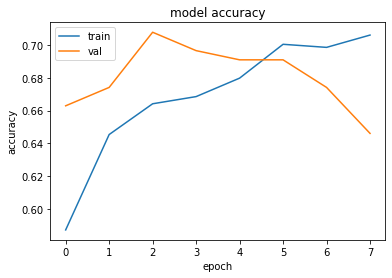

198/198 [==============================] - 0s 1ms/step
Accuracy: 52.525252
Original Accuracy: 0.405680
Confusion Matrix:  [[33 46]
 [48 71]]
tn, fp, fn, tp:   33 46 48 71
acc: 0.525253
precision: 0.606838
recall: 0.596639
auc: 0.538507
casual =========================================
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 132, 100)          878100    
_________________________________________________________________
masking_10 (Masking)         (None, 132, 100)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_20 (Dense)             (No

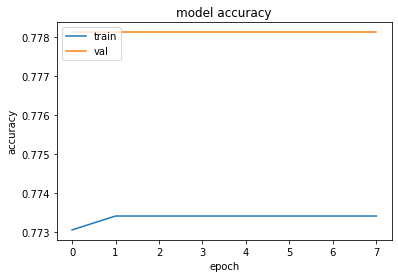

346/346 [==============================] - 0s 798us/step
Accuracy: 80.057806
Original Accuracy: 0.223444
Confusion Matrix:  [[  0  69]
 [  0 277]]
tn, fp, fn, tp:   0 69 0 277
acc: 0.800578
precision: 0.800578
recall: 1.000000
auc: 0.491760
classic =========================================
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 187, 100)          747200    
_________________________________________________________________
masking_11 (Masking)         (None, 187, 100)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dense_21 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_22 (Dense)          

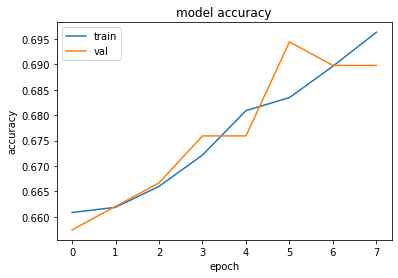

240/240 [==============================] - 0s 1ms/step
Accuracy: 71.666664
Original Accuracy: 0.334306
Confusion Matrix:  [[  8  64]
 [  4 164]]
tn, fp, fn, tp:   8 64 4 164
acc: 0.716667
precision: 0.719298
recall: 0.976190
auc: 0.555556
edgy =========================================
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 132, 100)          622100    
_________________________________________________________________
masking_12 (Masking)         (None, 132, 100)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_24 (Dense)             (N

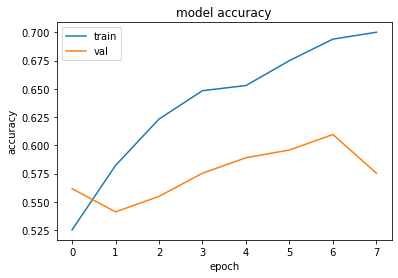

163/163 [==============================] - 0s 918us/step
Accuracy: 63.803679
Original Accuracy: 0.494147
Confusion Matrix:  [[48 27]
 [32 56]]
tn, fp, fn, tp:   48 27 32 56
acc: 0.638037
precision: 0.674699
recall: 0.636364
auc: 0.666136
glam =========================================
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 138, 100)          575700    
_________________________________________________________________
masking_13 (Masking)         (None, 138, 100)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_26 (Dense)             (No

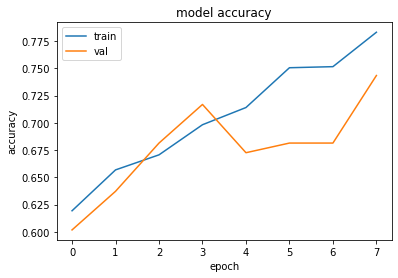

126/126 [==============================] - 0s 872us/step
Accuracy: 70.634919
Original Accuracy: 0.641660
Confusion Matrix:  [[66 18]
 [19 23]]
tn, fp, fn, tp:   66 18 19 23
acc: 0.706349
precision: 0.560976
recall: 0.547619
auc: 0.746740
modern =========================================
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 187, 100)          812900    
_________________________________________________________________
masking_14 (Masking)         (None, 187, 100)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_28 (Dense)             (

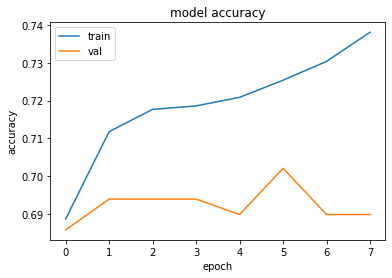

273/273 [==============================] - 0s 1ms/step
Accuracy: 72.527474
Original Accuracy: 0.294745
Confusion Matrix:  [[ 18  62]
 [ 13 180]]
tn, fp, fn, tp:   18 62 13 180
acc: 0.725275
precision: 0.743802
recall: 0.932642
auc: 0.575486
retro =========================================
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 169, 100)          527400    
_________________________________________________________________
masking_15 (Masking)         (None, 169, 100)          0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dense_29 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_30 (Dense)            

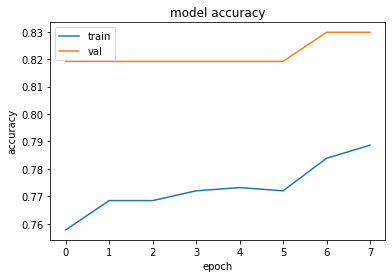

105/105 [==============================] - 0s 1ms/step
Accuracy: 79.047620
Original Accuracy: 0.772334
Confusion Matrix:  [[78  2]
 [20  5]]
tn, fp, fn, tp:   78 2 20 5
acc: 0.790476
precision: 0.714286
recall: 0.200000
auc: 0.626500
romantic =========================================
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 145, 100)          593200    
_________________________________________________________________
masking_16 (Masking)         (None, 145, 100)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dense_31 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_32 (Dense)             (No

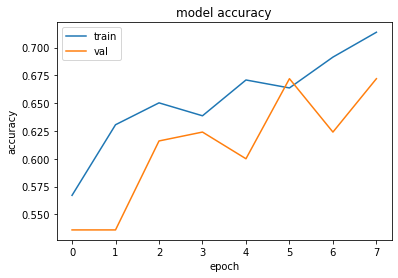

139/139 [==============================] - 0s 1ms/step
Accuracy: 64.748204
Original Accuracy: 0.581766
Confusion Matrix:  [[51 27]
 [22 39]]
tn, fp, fn, tp:   51 27 22 39
acc: 0.647482
precision: 0.590909
recall: 0.639344
auc: 0.699769


In [102]:
acclist = []
precisionlist = []
recalllist = []
auclist = []

for style in stylelist:
    
    print(style,'=========================================')
    
    for loop in range(10):
        data = Style.groupby('tag_info').agg(style = pd.NamedAgg(column=style, aggfunc='max')).reset_index()
        data1 = data[data[style]==1]
        data2 = data[data[style]==0]..sample(round(len(data1)*1.5), random_state=123)
        data = pd.concat([data1, data2])
        tag_list = list(data['tag_info'])

        # Tokenize the Text
        tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
        tokenizer.fit_on_texts(tag_list)

        # get the max length in terms of token length
        max_length = get_max_token_length_per_doc(tag_list)

        # integer encode the documents
        encoded_docs = integer_encode_documents(tag_list, tokenizer)
        # this is a list of lists, the numbers represent the index position of that word.
        # for instance, 33 means the 33rd word in the vocabulary
        # Notice the last document has 4 numbers, since it is a 4 word document: Could have done better.
        padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

        encoder = LabelEncoder()
        labels = data[style]
        labels = to_categorical(encoder.fit_transform(labels))

        X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.1, random_state=23)

        VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

        # Load in Embeddings
        # create a weight matrix for words in training docs
        embedding_matrix = zeros((VOCAB_SIZE, 100))
        for word, i in tokenizer.word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None: # check that it is an actual word that we have embeddings for
                embedding_matrix[i] = embedding_vector

        model = make_lstm_classification_model()
        history = model.fit(X_train, y_train,validation_split = 0.1, epochs=15, verbose=0)

        y_prob = model.predict(X_test) 
        y_classes = y_prob.argmax(axis=-1)
        ytest = [np.argmax(y, axis=None, out=None) for y in y_test]
        # acc
        acc = sklearn.metrics.accuracy_score(ytest, y_classes)
        # precision 
        precision = sklearn.metrics.precision_score(ytest, y_classes)
        # recall
        recall = sklearn.metrics.recall_score(ytest, y_classes)
        # auc
        auc = sklearn.metrics.roc_auc_score(ytest, [y[1] for y in y_prob])

        acclist.append(acc)
        precisionlist.append(precision)
        recalllist.append(recall)
        auclist.append(auc)

    print('acc: %f' % np.mean(acclist))
    print('precision: %f' % np.mean(precisionlist))
    print('recall: %f' % np.mean(recalllist))
    print('auc: %f' % np.mean(auclist))